# LiDAR 기본 원리와 데이터 구조 이해

이 노트북에서는 자율주행에서 사용되는 LiDAR(Light Detection And Ranging) 센서의 기본 원리와 데이터 구조에 대해 다루고, 
포인트 클라우드 데이터를 시각화하고 간단히 처리하는 방법을 배웁니다.

## 1. LiDAR 기본 개념과 원리

LiDAR는 레이저 펄스를 발사하고 물체에 반사되어 돌아오는 시간을 측정하여 거리를 계산하는 센서입니다.
자율주행 차량에서는 주로 360도를 회전하면서 스캔하는 기계식 LiDAR와 회전 부품 없이 특정 영역을 스캔하는 
솔리드 스테이트(Solid-State) LiDAR가 사용됩니다.

### LiDAR 작동 원리
1. 레이저 펄스 발사
2. 물체에 반사
3. 센서로 돌아오는 시간 측정
4. 거리 계산: 거리 = (빛의 속도 × 왕복 시간) / 2

다음은 이를 시각적으로 표현한 간단한 코드입니다.

물체 1: 거리 5m, 왕복 시간 33.36 나노초
물체 2: 거리 10m, 왕복 시간 66.71 나노초
물체 3: 거리 15m, 왕복 시간 100.07 나노초
물체 4: 거리 20m, 왕복 시간 133.43 나노초


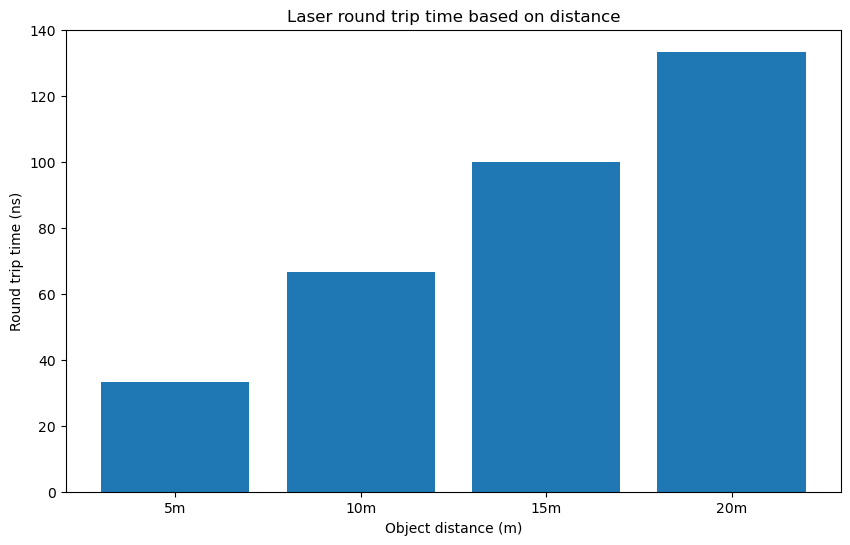

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def simulate_lidar_principle():
    # 빛의 속도 (m/s)
    speed_of_light = 299792458
    
    # 가상의 물체 거리 (미터)
    distances = [5, 10, 15, 20]
    
    # 왕복 시간 계산 (나노초)
    times = [(2 * d / speed_of_light) * 1e9 for d in distances]
    
    # 결과 출력
    for i, (d, t) in enumerate(zip(distances, times)):
        print(f"물체 {i+1}: 거리 {d}m, 왕복 시간 {t:.2f} 나노초")
    
    # 시각화
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(len(distances)), times)
    ax.set_xticks(range(len(distances)))
    ax.set_xticklabels([f"{d}m" for d in distances])
    ax.set_ylabel('Round trip time (ns)')
    ax.set_xlabel('Object distance (m)')
    ax.set_title('Laser round trip time based on distance')
    plt.show()

# 시뮬레이션 실행
simulate_lidar_principle()


## 2. LiDAR 데이터 구조

LiDAR는 포인트 클라우드(Point Cloud) 형태로 데이터를 제공합니다. 각 포인트는 일반적으로 다음 정보를 포함합니다:

- x, y, z: 3D 공간 좌표
- intensity: 반사 강도 (물체의 반사율에 따라 달라짐)
- ring/channel: 레이저 채널 정보 (수직 해상도)
- timestamp: 측정 시간

다양한 포맷으로 저장되지만, 주로 PCD(Point Cloud Data), LAS, PLY 등의 형식이나, 
KITTI 데이터셋과 같은 자율주행 벤치마크에서는 bin 파일 형태로 제공되기도 합니다.

In [3]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 3. KITTI 데이터셋의 LiDAR 데이터 로드 및 시각화

KITTI 데이터셋은 자율주행 연구에 널리 사용되는 벤치마크 데이터셋입니다.
여기서는 KITTI 형식의 bin 파일에서 포인트 클라우드를 로드하고 시각화하는 방법을 알아봅니다.

In [4]:
def load_kitti_point_cloud(bin_file_path):
    """
    KITTI 데이터셋의 bin 파일에서 포인트 클라우드를 로드합니다.
    
    Args:
        bin_file_path: bin 파일 경로
        
    Returns:
        points: Nx4 배열 (x, y, z, intensity)
    """
    # bin 파일에서 포인트 클라우드 로드
    points = np.fromfile(bin_file_path, dtype=np.float32).reshape(-1, 4)
    return points

def visualize_point_cloud(points, intensity=False):
    """
    Open3D를 사용하여 포인트 클라우드를 시각화합니다.
    
    Args:
        points: Nx3 or Nx4 배열 (x, y, z, [intensity])
        intensity: 반사 강도를 색상으로 표현할지 여부
    """
    # Open3D 포인트 클라우드 객체 생성
    pcd = o3d.geometry.PointCloud()
    
    # 좌표 설정 (x, y, z)
    pcd.points = o3d.utility.Vector3dVector(points[:, :3])
    
    # 반사 강도를 색상으로 표현
    if intensity and points.shape[1] >= 4:
        # 강도 정규화 (0-1 범위)
        intensity_values = points[:, 3]
        max_intensity = np.max(intensity_values)
        if max_intensity > 0:
            intensity_normalized = intensity_values / max_intensity
        else:
            intensity_normalized = intensity_values
            
        # 색상 설정 (강도에 따른 그레이스케일)
        colors = np.zeros((points.shape[0], 3))
        colors[:, 0] = intensity_normalized  # R
        colors[:, 1] = intensity_normalized  # G
        colors[:, 2] = intensity_normalized  # B
        pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # 좌표계 시각화 (빨간색: x축, 녹색: y축, 파란색: z축)
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=3.0)
    
    # 시각화
    o3d.visualization.draw_geometries([pcd, coordinate_frame])

# 데이터 경로 (데이터셋이 다운로드된 경로로 수정 필요)
# 실제 사용 시에는 아래 경로를 수정해야 합니다
# 데이터 경로 설정
data_dir = '/home/shbyun/KITTI/ObjectDetection/'
point_cloud_dir = os.path.join(data_dir, 'data_object_velodyne/training', 'velodyne')
sample_file = "000000.bin"  # 예시 파일명
sample_path = os.path.join(point_cloud_dir, sample_file)

if os.path.exists(sample_path):
    # 포인트 클라우드 로드
    points = load_kitti_point_cloud(sample_path)
    print(f"로드된 포인트 수: {points.shape[0]}")
    
    # 포인트 클라우드 시각화
    visualize_point_cloud(points, intensity=True)
else:
    print(f"파일을 찾을 수 없습니다: {sample_path}")
    print("데이터 디렉토리를 확인하거나 데이터셋을 다운로드하세요.")


로드된 포인트 수: 115384


## 4. 가상 포인트 클라우드 생성 및 시각화

실제 KITTI 데이터셋이 없는 경우를 대비하여, 가상의 포인트 클라우드를 생성하고 시각화해봅니다.

In [5]:
def generate_virtual_point_cloud(num_points=10000):
    """
    간단한 가상 환경의 포인트 클라우드를 생성합니다.
    - 지면, 두 개의 차량, 몇 개의 나무로 구성된 장면
    
    Args:
        num_points: 생성할 총 포인트 수
        
    Returns:
        points: Nx4 배열 (x, y, z, intensity)
    """
    # 빈 포인트 클라우드 생성
    points = np.zeros((num_points, 4))
    
    # 1. 지면 포인트 (전체의 60%)
    ground_points = int(num_points * 0.6)
    x_ground = np.random.uniform(-20, 20, ground_points)
    y_ground = np.random.uniform(-20, 20, ground_points)
    z_ground = np.random.uniform(-0.1, 0.1, ground_points)  # 약간의 노이즈
    intensity_ground = np.random.uniform(0.1, 0.3, ground_points)  # 낮은 반사율
    
    points[:ground_points, 0] = x_ground
    points[:ground_points, 1] = y_ground
    points[:ground_points, 2] = z_ground
    points[:ground_points, 3] = intensity_ground
    
    # 2. 차량 1 (전체의 15%)
    car1_points = int(num_points * 0.15)
    car1_center = np.array([5, 10, 0.5])
    car1_size = np.array([2, 4.5, 1.5])
    
    idx = ground_points
    for i in range(car1_points):
        # 차량 표면에 포인트 배치
        face = np.random.randint(0, 6)  # 6개 면 중 하나
        if face == 0:  # 전면
            x = car1_center[0] - car1_size[0]/2
            y = np.random.uniform(car1_center[1] - car1_size[1]/2, car1_center[1] + car1_size[1]/2)
            z = np.random.uniform(car1_center[2] - car1_size[2]/2, car1_center[2] + car1_size[2]/2)
        elif face == 1:  # 후면
            x = car1_center[0] + car1_size[0]/2
            y = np.random.uniform(car1_center[1] - car1_size[1]/2, car1_center[1] + car1_size[1]/2)
            z = np.random.uniform(car1_center[2] - car1_size[2]/2, car1_center[2] + car1_size[2]/2)
        elif face == 2:  # 좌측
            x = np.random.uniform(car1_center[0] - car1_size[0]/2, car1_center[0] + car1_size[0]/2)
            y = car1_center[1] - car1_size[1]/2
            z = np.random.uniform(car1_center[2] - car1_size[2]/2, car1_center[2] + car1_size[2]/2)
        elif face == 3:  # 우측
            x = np.random.uniform(car1_center[0] - car1_size[0]/2, car1_center[0] + car1_size[0]/2)
            y = car1_center[1] + car1_size[1]/2
            z = np.random.uniform(car1_center[2] - car1_size[2]/2, car1_center[2] + car1_size[2]/2)
        elif face == 4:  # 상단
            x = np.random.uniform(car1_center[0] - car1_size[0]/2, car1_center[0] + car1_size[0]/2)
            y = np.random.uniform(car1_center[1] - car1_size[1]/2, car1_center[1] + car1_size[1]/2)
            z = car1_center[2] + car1_size[2]/2
        else:  # 하단 (보이지 않음)
            x = np.random.uniform(car1_center[0] - car1_size[0]/2, car1_center[0] + car1_size[0]/2)
            y = np.random.uniform(car1_center[1] - car1_size[1]/2, car1_center[1] + car1_size[1]/2)
            z = car1_center[2] - car1_size[2]/2
        
        # 약간의 노이즈 추가
        x += np.random.normal(0, 0.02)
        y += np.random.normal(0, 0.02)
        z += np.random.normal(0, 0.02)
        
        # 포인트 정보 저장
        points[idx, 0] = x
        points[idx, 1] = y
        points[idx, 2] = z
        points[idx, 3] = np.random.uniform(0.5, 0.9)  # 높은 반사율
        idx += 1
    
    # 3. 차량 2 (전체의 15%)
    car2_points = int(num_points * 0.15)
    car2_center = np.array([-8, -5, 0.5])
    car2_size = np.array([2, 4.5, 1.5])
    
    for i in range(car2_points):
        # 차량 1과 동일한 방식
        face = np.random.randint(0, 6) 
        if face == 0:
            x = car2_center[0] - car2_size[0]/2
            y = np.random.uniform(car2_center[1] - car2_size[1]/2, car2_center[1] + car2_size[1]/2)
            z = np.random.uniform(car2_center[2] - car2_size[2]/2, car2_center[2] + car2_size[2]/2)
        elif face == 1:
            x = car2_center[0] + car2_size[0]/2
            y = np.random.uniform(car2_center[1] - car2_size[1]/2, car2_center[1] + car2_size[1]/2)
            z = np.random.uniform(car2_center[2] - car2_size[2]/2, car2_center[2] + car2_size[2]/2)
        elif face == 2:
            x = np.random.uniform(car2_center[0] - car2_size[0]/2, car2_center[0] + car2_size[0]/2)
            y = car2_center[1] - car2_size[1]/2
            z = np.random.uniform(car2_center[2] - car2_size[2]/2, car2_center[2] + car2_size[2]/2)
        elif face == 3:
            x = np.random.uniform(car2_center[0] - car2_size[0]/2, car2_center[0] + car2_size[0]/2)
            y = car2_center[1] + car2_size[1]/2
            z = np.random.uniform(car2_center[2] - car2_size[2]/2, car2_center[2] + car2_size[2]/2)
        elif face == 4:
            x = np.random.uniform(car2_center[0] - car2_size[0]/2, car2_center[0] + car2_size[0]/2)
            y = np.random.uniform(car2_center[1] - car2_size[1]/2, car2_center[1] + car2_size[1]/2)
            z = car2_center[2] + car2_size[2]/2
        else:
            x = np.random.uniform(car2_center[0] - car2_size[0]/2, car2_center[0] + car2_size[0]/2)
            y = np.random.uniform(car2_center[1] - car2_size[1]/2, car2_center[1] + car2_size[1]/2)
            z = car2_center[2] - car2_size[2]/2
        
        x += np.random.normal(0, 0.02)
        y += np.random.normal(0, 0.02)
        z += np.random.normal(0, 0.02)
        
        points[idx, 0] = x
        points[idx, 1] = y
        points[idx, 2] = z
        points[idx, 3] = np.random.uniform(0.5, 0.9)
        idx += 1
    
    # 4. 나무/기둥 (전체의 10%)
    tree_points = num_points - idx
    
    for i in range(tree_points):
        # 무작위로 3개의 나무 중 하나 선택
        tree_idx = np.random.randint(0, 3)
        
        if tree_idx == 0:
            tree_center = np.array([10, -8, 3])
        elif tree_idx == 1:
            tree_center = np.array([-5, 15, 3])
        else:
            tree_center = np.array([-12, -10, 3])
            
        # 나무 기둥
        if np.random.rand() < 0.3:
            x = tree_center[0] + np.random.normal(0, 0.3)
            y = tree_center[1] + np.random.normal(0, 0.3)
            z = np.random.uniform(0, tree_center[2])
        # 나무 잎
        else:
            radius = np.random.uniform(0, 2)
            theta = np.random.uniform(0, 2*np.pi)
            phi = np.random.uniform(0, np.pi)
            
            x = tree_center[0] + radius * np.sin(phi) * np.cos(theta)
            y = tree_center[1] + radius * np.sin(phi) * np.sin(theta)
            z = tree_center[2] + radius * np.cos(phi)
        
        points[idx, 0] = x
        points[idx, 1] = y
        points[idx, 2] = z
        points[idx, 3] = np.random.uniform(0.2, 0.5)  # 중간 정도의 반사율
        idx += 1
    
    return points

# 가상 포인트 클라우드 생성
virtual_points = generate_virtual_point_cloud(20000)
print(f"생성된 가상 포인트 수: {virtual_points.shape[0]}")

# 가상 포인트 클라우드 시각화
visualize_point_cloud(virtual_points, intensity=True)

생성된 가상 포인트 수: 20000


## 5. 포인트 클라우드 기본 처리 기법

포인트 클라우드 데이터를 활용하기 위한 기본적인 처리 기법들을 알아봅니다.


In [6]:
def downsample_point_cloud(points, voxel_size=0.5):
    """
    포인트 클라우드 다운샘플링 (복셀 그리드 방식)
    
    Args:
        points: Nx4 배열 (x, y, z, intensity)
        voxel_size: 복셀 크기 (미터)
        
    Returns:
        downsampled_points: 다운샘플링된 포인트 클라우드
    """
    # Open3D 포인트 클라우드 객체 생성
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points[:, :3])
    
    # 반사 강도를 색상으로 설정 (시각화 목적)
    intensity_normalized = points[:, 3] / np.max(points[:, 3])
    colors = np.zeros((points.shape[0], 3))
    colors[:, 0] = intensity_normalized
    colors[:, 1] = intensity_normalized
    colors[:, 2] = intensity_normalized
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # 다운샘플링 수행
    downsampled_pcd = pcd.voxel_down_sample(voxel_size)
    
    # 결과 추출
    downsampled_points = np.asarray(downsampled_pcd.points)
    downsampled_colors = np.asarray(downsampled_pcd.colors)
    
    # 다운샘플링된 포인트와 강도 값 결합
    result = np.zeros((downsampled_points.shape[0], 4))
    result[:, :3] = downsampled_points
    result[:, 3] = downsampled_colors[:, 0]  # 강도 값은 색상의 첫 번째 채널에서 가져옴
    
    return result

def filter_points_by_distance(points, min_dist=0, max_dist=100):
    """
    거리에 기반하여 포인트 필터링
    
    Args:
        points: Nx4 배열 (x, y, z, intensity)
        min_dist: 최소 거리 (미터)
        max_dist: 최대 거리 (미터)
        
    Returns:
        filtered_points: 필터링된 포인트 클라우드
    """
    # 각 포인트의 거리 계산 (원점으로부터)
    distances = np.sqrt(np.sum(points[:, :3]**2, axis=1))
    
    # 거리 조건에 맞는 포인트 선택
    mask = (distances >= min_dist) & (distances <= max_dist)
    filtered_points = points[mask]
    
    return filtered_points

# 가상 포인트 클라우드 다운샘플링 및 시각화
downsampled_points = downsample_point_cloud(virtual_points, voxel_size=0.5)
print(f"다운샘플링 전 포인트 수: {virtual_points.shape[0]}")
print(f"다운샘플링 후 포인트 수: {downsampled_points.shape[0]}")

# 시각화
visualize_point_cloud(downsampled_points, intensity=True)

# 거리 기반 필터링 및 시각화
filtered_points = filter_points_by_distance(virtual_points, min_dist=5, max_dist=15)
print(f"필터링 전 포인트 수: {virtual_points.shape[0]}")
print(f"필터링 후 포인트 수: {filtered_points.shape[0]}")

# 시각화
visualize_point_cloud(filtered_points, intensity=True)

다운샘플링 전 포인트 수: 20000
다운샘플링 후 포인트 수: 7953
필터링 전 포인트 수: 20000
필터링 후 포인트 수: 11362


## 6. LiDAR 좌표계와 변환

LiDAR 데이터는 보통 센서 중심의 좌표계로 표현됩니다. 자율주행에서는 이를 다양한 좌표계로 변환하는 작업이 필요합니다.

주요 좌표계:
- 센서 좌표계: LiDAR 센서를 원점으로 하는 좌표계
- 차량 좌표계: 차량의 중앙을 원점으로 하는 좌표계
- 세계 좌표계: 주행 환경의 특정 지점을 원점으로 하는 좌표계

In [7]:
def transform_point_cloud(points, transformation_matrix):
    """
    포인트 클라우드를 변환 행렬을 사용하여 변환
    
    Args:
        points: Nx3 또는 Nx4 배열 (x, y, z, [intensity])
        transformation_matrix: 4x4 변환 행렬
        
    Returns:
        transformed_points: 변환된 포인트 클라우드
    """
    # 포인트 복사
    transformed_points = points.copy()
    
    # 동차 좌표로 변환 (x, y, z, 1)
    homogeneous_points = np.ones((points.shape[0], 4))
    homogeneous_points[:, :3] = points[:, :3]
    
    # 변환 적용
    transformed_homogeneous = np.dot(homogeneous_points, transformation_matrix.T)
    
    # 변환된 좌표 업데이트
    transformed_points[:, :3] = transformed_homogeneous[:, :3]
    
    return transformed_points

# LiDAR 센서 좌표계에서 차량 좌표계로 변환하는 예
# 예: LiDAR가 차량 위에 (x=0, y=0, z=1.8) 위치하고 있고, 약간 회전되어 있는 경우
def lidar_to_vehicle_transform():
    """
    LiDAR 센서 좌표계에서 차량 좌표계로의 변환 행렬 생성
    """
    # 회전 (라디안) - x축 기준 약간의 회전 (피치)
    pitch = np.radians(5)
    
    # 회전 행렬
    Rx = np.array([
        [1, 0, 0, 0],
        [0, np.cos(pitch), -np.sin(pitch), 0],
        [0, np.sin(pitch), np.cos(pitch), 0],
        [0, 0, 0, 1]
    ])
    
    # 이동 (미터) - LiDAR가 차량 루프에 장착된 경우
    tx, ty, tz = 0, 0, 1.8
    
    # 이동 행렬
    T = np.array([
        [1, 0, 0, tx],
        [0, 1, 0, ty],
        [0, 0, 1, tz],
        [0, 0, 0, 1]
    ])
    
    # 최종 변환 행렬 (회전 후 이동)
    transform = np.dot(T, Rx)
    
    return transform

# 차량 좌표계에서 LiDAR 센서 좌표계로의 변환 행렬 (역변환)
def vehicle_to_lidar_transform():
    """
    차량 좌표계에서 LiDAR 센서 좌표계로의 변환 행렬 생성 (역변환)
    """
    lidar_to_vehicle = lidar_to_vehicle_transform()
    vehicle_to_lidar = np.linalg.inv(lidar_to_vehicle)
    return vehicle_to_lidar

# 좌표계 변환 예시
lidar_to_vehicle = lidar_to_vehicle_transform()
vehicle_to_lidar = vehicle_to_lidar_transform()

# 가상의 차량 좌표계 포인트 생성 (도로 모델)
def generate_road_in_vehicle_coords(num_points=5000):
    """
    차량 좌표계에서 도로를 표현하는 포인트 클라우드 생성
    """
    points = np.zeros((num_points, 4))
    
    # x축: 차량 전방
    # y축: 차량 좌측
    # z축: 차량 상방
    
    # 도로 폭 (+/-5 미터)
    road_width = 10
    # 도로 길이 (전방 50m, 후방 10m)
    road_length = 60
    
    # 도로 기본 포인트
    x = np.random.uniform(-10, 50, num_points)
    y = np.random.uniform(-road_width/2, road_width/2, num_points)
    z = np.zeros(num_points)  # 도로 높이 (차량 좌표계에서 0)
    
    # 약간의 노이즈 추가
    z += np.random.normal(0, 0.03, num_points)
    
    points[:, 0] = x
    points[:, 1] = y
    points[:, 2] = z
    points[:, 3] = np.random.uniform(0.1, 0.3, num_points)  # 도로의 낮은 반사율
    
    return points

# 차량 좌표계에서 도로 포인트 생성
road_vehicle_coords = generate_road_in_vehicle_coords(10000)

# LiDAR 센서 좌표계로 변환
road_lidar_coords = transform_point_cloud(road_vehicle_coords, vehicle_to_lidar)

# 시각화
print("차량 좌표계의 도로 포인트:")
visualize_point_cloud(road_vehicle_coords, intensity=True)

print("LiDAR 센서 좌표계로 변환된 도로 포인트:")
visualize_point_cloud(road_lidar_coords, intensity=True)

차량 좌표계의 도로 포인트:
LiDAR 센서 좌표계로 변환된 도로 포인트:


## 7. 거리 이미지(Range Image) 변환

LiDAR 포인트 클라우드는 3D 데이터이지만, 2D 이미지로 변환하여 처리하는 방법도 많이 사용됩니다.
거리 이미지(Range Image)는 각 픽셀이 특정 방향의 거리 값을 나타내는 2D 이미지입니다.


In [ ]:
def point_cloud_to_range_image(points, h_res=0.2, v_res=0.4, h_fov=(-180, 180), v_fov=(-15, 15)):
    """
    포인트 클라우드를 거리 이미지로 변환
    
    Args:
        points: Nx4 배열 (x, y, z, intensity)
        h_res: 수평 해상도 (도)
        v_res: 수직 해상도 (도)
        h_fov: 수평 시야각 범위 (도)
        v_fov: 수직 시야각 범위 (도)
        
    Returns:
        range_image: 거리 이미지 (높이 x 너비)
        intensity_image: 반사 강도 이미지 (높이 x 너비)
    """
    # 각도 범위 계산
    h_range = h_fov[1] - h_fov[0]
    v_range = v_fov[1] - v_fov[0]
    
    # 이미지 크기 계산
    width = int(np.ceil(h_range / h_res))
    height = int(np.ceil(v_range / v_res))
    
    # 초기 이미지 생성 (모든 픽셀을 무한대로 설정)
    range_image = np.full((height, width), np.inf)
    intensity_image = np.zeros((height, width))
    
    # 각 포인트에 대해
    for i, point in enumerate(points):
        x, y, z, intensity = point
        
        # 구면 좌표계로 변환
        distance = np.sqrt(x**2 + y**2 + z**2)
        
        if distance == 0:
            continue
            
        # 방위각 계산 (수평각)
        yaw = np.arctan2(y, x) * 180 / np.pi
        # 고도각 계산 (수직각)
        pitch = np.arcsin(z / distance) * 180 / np.pi
        
        # 이미지 좌표 계산
        col = int((yaw - h_fov[0]) / h_res)
        row = int((pitch - v_fov[0]) / v_res)
        
        # 유효한 이미지 범위인지 확인
        if 0 <= row < height and 0 <= col < width:
            # 같은 픽셀에 여러 포인트가 있는 경우, 가장 가까운 것을 선택
            if distance < range_image[row, col]:
                range_image[row, col] = distance
                intensity_image[row, col] = intensity
    
    return range_image, intensity_image

def visualize_range_image(range_image, intensity_image):
    """
    거리 이미지와 강도 이미지 시각화
    """
    # 무한대 값을 0으로 설정 (배경)
    range_vis = np.copy(range_image)
    range_vis[np.isinf(range_vis)] = 0
    
    # 거리 정규화 (시각화용)
    if np.max(range_vis) > 0:
        range_vis = range_vis / np.max(range_vis)
    
    # 강도 정규화 (시각화용)
    intensity_vis = np.copy(intensity_image)
    if np.max(intensity_vis) > 0:
        intensity_vis = intensity_vis / np.max(intensity_vis)
    
    # 시각화
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    # 거리 이미지
    im0 = axes[0].imshow(range_vis, cmap='viridis')
    axes[0].set_title('Range Image')
    plt.colorbar(im0, ax=axes[0])
    
    # 강도 이미지
    im1 = axes[1].imshow(intensity_vis, cmap='gray')
    axes[1].set_title('Intensity Image')
    plt.colorbar(im1, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

# 가상 포인트 클라우드를 거리 이미지로 변환
range_img, intensity_img = point_cloud_to_range_image(virtual_points)

# 거리 이미지 시각화
visualize_range_image(range_img, intensity_img)

## 8. BEV(Bird's Eye View) 변환

BEV(Bird's Eye View)는 포인트 클라우드를 위에서 내려다본 2D 이미지로 변환한 것입니다.
자율주행에서 도로 및 객체 인식에 유용하게 사용됩니다.

In [ ]:
def point_cloud_to_bev(points, x_range=(-20, 20), y_range=(-20, 20), z_range=(-2, 4), res=0.1):
    """
    포인트 클라우드를 BEV 이미지로 변환
    
    Args:
        points: Nx4 배열 (x, y, z, intensity)
        x_range: x축 범위 (미터)
        y_range: y축 범위 (미터)
        z_range: z축 범위 (미터)
        res: 해상도 (미터/픽셀)
        
    Returns:
        height_map: 높이 정보를 포함한 BEV 이미지
        intensity_map: 반사 강도 정보를 포함한 BEV 이미지
        density_map: 밀도 정보를 포함한 BEV 이미지
    """
    # 이미지 크기 계산
    x_size = int((x_range[1] - x_range[0]) / res)
    y_size = int((y_range[1] - y_range[0]) / res)
    
    # 이미지 초기화
    height_map = np.zeros((y_size, x_size))
    intensity_map = np.zeros((y_size, x_size))
    density_map = np.zeros((y_size, x_size))
    
    # z축 범위 내의 포인트만 사용
    mask = (points[:, 2] >= z_range[0]) & (points[:, 2] <= z_range[1])
    filtered_points = points[mask]
    
    # 각 포인트에 대해
    for point in filtered_points:
        x, y, z, intensity = point
        
        # 이미지 좌표로 변환
        x_img = int((x - x_range[0]) / res)
        y_img = int((y - y_range[0]) / res)
        
        # 이미지 범위 내인지 확인
        if 0 <= x_img < x_size and 0 <= y_img < y_size:
            # 기존 높이보다 높은 경우 업데이트
            if z > height_map[y_img, x_img]:
                height_map[y_img, x_img] = z
                intensity_map[y_img, x_img] = intensity
                
            # 밀도 맵 업데이트
            density_map[y_img, x_img] += 1
    
    return height_map, intensity_map, density_map

def visualize_bev(height_map, intensity_map, density_map):
    """
    BEV 이미지 시각화
    """
    # 높이 정규화
    if np.max(height_map) > 0:
        height_vis = height_map / np.max(height_map)
    else:
        height_vis = height_map
        
    # 강도 정규화
    if np.max(intensity_map) > 0:
        intensity_vis = intensity_map / np.max(intensity_map)
    else:
        intensity_vis = intensity_map
        
    # 밀도 정규화
    if np.max(density_map) > 0:
        density_vis = np.log1p(density_map) / np.log1p(np.max(density_map))
    else:
        density_vis = density_map
    
    # 시각화
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 높이 맵
    im0 = axes[0].imshow(height_vis, cmap='viridis', origin='lower')
    axes[0].set_title('Height Map')
    plt.colorbar(im0, ax=axes[0])
    
    # 강도 맵
    im1 = axes[1].imshow(intensity_vis, cmap='gray', origin='lower')
    axes[1].set_title('Intensity Map')
    plt.colorbar(im1, ax=axes[1])
    
    # 밀도 맵
    im2 = axes[2].imshow(density_vis, cmap='hot', origin='lower')
    axes[2].set_title('Density Map')
    plt.colorbar(im2, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

# 가상 포인트 클라우드를 BEV로 변환
height_map, intensity_map, density_map = point_cloud_to_bev(virtual_points)

# BEV 시각화
visualize_bev(height_map, intensity_map, density_map)

## 9. 포인트 클라우드 세그먼테이션 기초

포인트 클라우드 세그먼테이션은 각 포인트를 의미 있는 객체나 영역으로 분류하는 과정입니다.
여기서는 간단한 지면 세그먼테이션 방법을 알아봅니다.


In [ ]:
def simple_ground_segmentation(points, height_threshold=0.5, max_iterations=1000, distance_threshold=0.1):
    """
    RANSAC 기반 지면 세그먼테이션
    
    Args:
        points: Nx4 배열 (x, y, z, intensity)
        height_threshold: 지면으로 간주할 최대 높이 차이
        max_iterations: RANSAC 최대 반복 횟수
        distance_threshold: 지면 모델에서의 최대 허용 거리
        
    Returns:
        ground_points: 지면으로 분류된 포인트
        non_ground_points: 지면이 아닌 것으로 분류된 포인트
    """
    # 포인트 클라우드를 Open3D 형식으로 변환
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points[:, :3])
    
    # 평면 분할 (RANSAC 사용)
    plane_model, inliers = pcd.segment_plane(distance_threshold, 
                                          max_iterations, 
                                          3)  # 최소 3개의 점 필요
    
    # 평면 모델 파라미터 (ax + by + cz + d = 0)
    a, b, c, d = plane_model
    
    # 지면 법선 벡터가 대략 위쪽을 향하는지 확인 (z축 양의 방향)
    if c < 0:  # 법선 벡터가 아래쪽을 향하면 반전
        a, b, c, d = -a, -b, -c, -d
    
    # 인라이어(지면으로 간주)와 아웃라이어(비지면) 분리
    ground_indices = np.array(inliers)
    non_ground_indices = np.setdiff1d(np.arange(len(points)), ground_indices)
    
    ground_points = points[ground_indices]
    non_ground_points = points[non_ground_indices]
    
    return ground_points, non_ground_points, (a, b, c, d)

# 가상 포인트 클라우드에서 지면 세그먼테이션
ground_points, non_ground_points, plane_model = simple_ground_segmentation(virtual_points)

print(f"지면 포인트 수: {ground_points.shape[0]}")
print(f"비지면 포인트 수: {non_ground_points.shape[0]}")
print(f"평면 모델 파라미터 (ax + by + cz + d = 0): {plane_model}")

# 결과 시각화
print("지면 포인트:")
visualize_point_cloud(ground_points, intensity=True)

print("비지면 포인트:")
visualize_point_cloud(non_ground_points, intensity=True)

## 10. LiDAR 센서의 특성과 한계

LiDAR는 강력한 센서이지만 몇 가지 한계가 있습니다:

1. 해상도 제한: LiDAR의 해상도는 레이저 빔의 수와 스캔 패턴에 의해 제한됩니다.
2. 날씨 영향: 비, 안개, 눈 등은 레이저 빔을 산란시켜 정확도를 저하시킵니다.
3. 반사율 문제: 유리, 거울과 같은 반사성 물체나 검은색 물체는 레이저를 흡수하거나 반사시켜 감지를 어렵게 합니다.
4. 거리 제한: 일반적으로 100~200m 범위 내에서 정확도가 보장됩니다.

이러한 한계를 고려하여 자율주행 시스템에서는 LiDAR, 카메라, 레이더 등 다양한 센서를 융합하는 접근법을 사용합니다.

In [ ]:
def simulate_lidar_limitations():
    """
    LiDAR 센서의 한계를 시각화하는 간단한 시뮬레이션
    """
    # 1. 해상도 시뮬레이션
    
    # 가상의 물체 (직육면체)
    box_length, box_width, box_height = 2.0, 1.0, 1.5
    box_center = np.array([10, 0, 0.75])  # 10m 앞에 위치
    
    # 고해상도 포인트 클라우드 생성 (이상적인 경우)
    high_res_points = 1000
    high_res_cloud = np.zeros((high_res_points, 4))
    
    # 상자의 각 면에 포인트 배치
    points_per_face = high_res_points // 6
    idx = 0
    
    # 상자의 6개 면에 포인트 배치
    for face in range(6):
        for i in range(points_per_face):
            if face == 0:  # 앞면
                x = box_center[0] - box_length/2
                y = np.random.uniform(box_center[1] - box_width/2, box_center[1] + box_width/2)
                z = np.random.uniform(box_center[2] - box_height/2, box_center[2] + box_height/2)
            elif face == 1:  # 뒷면
                x = box_center[0] + box_length/2
                y = np.random.uniform(box_center[1] - box_width/2, box_center[1] + box_width/2)
                z = np.random.uniform(box_center[2] - box_height/2, box_center[2] + box_height/2)
            elif face == 2:  # 왼쪽면
                x = np.random.uniform(box_center[0] - box_length/2, box_center[0] + box_length/2)
                y = box_center[1] - box_width/2
                z = np.random.uniform(box_center[2] - box_height/2, box_center[2] + box_height/2)
            elif face == 3:  # 오른쪽면
                x = np.random.uniform(box_center[0] - box_length/2, box_center[0] + box_length/2)
                y = box_center[1] + box_width/2
                z = np.random.uniform(box_center[2] - box_height/2, box_center[2] + box_height/2)
            elif face == 4:  # 윗면
                x = np.random.uniform(box_center[0] - box_length/2, box_center[0] + box_length/2)
                y = np.random.uniform(box_center[1] - box_width/2, box_center[1] + box_width/2)
                z = box_center[2] + box_height/2
            else:  # 아랫면
                x = np.random.uniform(box_center[0] - box_length/2, box_center[0] + box_length/2)
                y = np.random.uniform(box_center[1] - box_width/2, box_center[1] + box_width/2)
                z = box_center[2] - box_height/2
                
            high_res_cloud[idx, 0] = x
            high_res_cloud[idx, 1] = y
            high_res_cloud[idx, 2] = z
            high_res_cloud[idx, 3] = 0.7  # 반사율
            idx += 1
    
    # 저해상도 시뮬레이션 (고해상도의 10%만 사용)
    low_res_samples = high_res_points // 10
    low_res_indices = np.random.choice(high_res_points, low_res_samples, replace=False)
    low_res_cloud = high_res_cloud[low_res_indices]
    
    # 2. 날씨 영향 시뮬레이션 (안개, 비)
    # 안개/비는 신호 감쇠와 노이즈 증가로 시뮬레이션
    
    # 안개 영향 시뮬레이션
    fog_cloud = high_res_cloud.copy()
    
    # 거리에 따른 감쇠 (멀수록 더 강하게 감쇠)
    distances = np.sqrt(np.sum(fog_cloud[:, :3]**2, axis=1))
    attenuation = np.exp(-0.1 * distances)  # 지수 감쇠 모델
    
    # 감쇠된 반사율
    fog_cloud[:, 3] = fog_cloud[:, 3] * attenuation
    
    # 일부 포인트 제거 (먼 포인트일수록 제거 확률 높음)
    removal_prob = 1 - attenuation
    mask = np.random.random(high_res_points) > removal_prob
    fog_cloud = fog_cloud[mask]
    
    # 랜덤 노이즈 추가
    noise_points = int(fog_cloud.shape[0] * 0.2)  # 20% 노이즈 추가
    noise_cloud = np.zeros((noise_points, 4))
    noise_cloud[:, 0] = np.random.uniform(0, 15, noise_points)  # x: 0~15m
    noise_cloud[:, 1] = np.random.uniform(-5, 5, noise_points)  # y: -5~5m
    noise_cloud[:, 2] = np.random.uniform(0, 3, noise_points)   # z: 0~3m
    noise_cloud[:, 3] = np.random.uniform(0.1, 0.3, noise_points)  # 낮은 반사율
    
    fog_cloud = np.vstack([fog_cloud, noise_cloud])
    
    # 3. 반사율 문제 시뮬레이션
    
    # 검은색/유리 물체 시뮬레이션 (낮은 반사율로 인한 포인트 손실)
    black_glass_box = np.zeros((points_per_face, 4))
    
    # 앞쪽 10m, 오른쪽 5m에 위치한 검은색/유리 상자
    black_glass_center = np.array([10, 5, 0.75])
    
    # 앞면만 포인트 생성 (다른 면은 검출되지 않음을 시뮬레이션)
    for i in range(points_per_face):
        x = black_glass_center[0] - box_length/2
        y = np.random.uniform(black_glass_center[1] - box_width/2, black_glass_center[1] + box_width/2)
        z = np.random.uniform(black_glass_center[2] - box_height/2, black_glass_center[2] + box_height/2)
        
        black_glass_box[i, 0] = x
        black_glass_box[i, 1] = y
        black_glass_box[i, 2] = z
        black_glass_box[i, 3] = 0.2  # 낮은 반사율
    
    # 결과 시각화
    fig = plt.figure(figsize=(15, 10))
    
    # 1. 고해상도 vs 저해상도
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter(high_res_cloud[:, 0], high_res_cloud[:, 1], high_res_cloud[:, 2], 
               c=high_res_cloud[:, 3], cmap='viridis', s=2)
    ax1.set_title('High Resolution LiDAR Scan')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_xlim([5, 15])
    ax1.set_ylim([-5, 5])
    ax1.set_zlim([0, 3])
    
    ax2 = fig.add_subplot(222, projection='3d')
    ax2.scatter(low_res_cloud[:, 0], low_res_cloud[:, 1], low_res_cloud[:, 2], 
               c=low_res_cloud[:, 3], cmap='viridis', s=10)
    ax2.set_title('Low Resolution LiDAR Scan')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_zlabel('Z (m)')
    ax2.set_xlim([5, 15])
    ax2.set_ylim([-5, 5])
    ax2.set_zlim([0, 3])
    
    # 2. 안개 영향
    ax3 = fig.add_subplot(223, projection='3d')
    ax3.scatter(fog_cloud[:, 0], fog_cloud[:, 1], fog_cloud[:, 2], 
               c=fog_cloud[:, 3], cmap='viridis', s=2)
    ax3.set_title('LiDAR Scan affected by fog/rain')
    ax3.set_xlabel('X (m)')
    ax3.set_ylabel('Y (m)')
    ax3.set_zlabel('Z (m)')
    ax3.set_xlim([0, 15])
    ax3.set_ylim([-5, 5])
    ax3.set_zlim([0, 3])
    
    # 3. 반사율 문제
    ax4 = fig.add_subplot(224, projection='3d')
    
    # 일반 상자 (완전히 감지됨)
    # ax4.scatter(high_res_cloud[:, 0], high_res_cloud[:, 1], high_res_cloud[:, 2], 
            #    c='blue', s=2, label='General Objects')
    
    # 검은색/유리 상자 (일부만 감지됨)
    ax4.scatter(black_glass_box[:, 0], black_glass_box[:, 1], black_glass_box[:, 2], 
               c='red', s=2, label='Low Reflectivity Object')

    # 물체의 실제 경계 표시 (와이어프레임) - 여기에 추가
    x, y, z = black_glass_center
    l, w, h = box_length, box_width, box_height
    
    vertices = np.array([
        [x-l/2, y-w/2, z-h/2], [x+l/2, y-w/2, z-h/2],
        [x+l/2, y+w/2, z-h/2], [x-l/2, y+w/2, z-h/2],
        [x-l/2, y-w/2, z+h/2], [x+l/2, y-w/2, z+h/2],
        [x+l/2, y+w/2, z+h/2], [x-l/2, y+w/2, z+h/2]
    ])

    edges = [
        [0, 1], [1, 2], [2, 3], [3, 0],
        [4, 5], [5, 6], [6, 7], [7, 4],
        [0, 4], [1, 5], [2, 6], [3, 7]
    ]

    for edge in edges:
        ax4.plot([vertices[edge[0], 0], vertices[edge[1], 0]],
                 [vertices[edge[0], 1], vertices[edge[1], 1]],
                 [vertices[edge[0], 2], vertices[edge[1], 2]],
                 'k-', alpha=0.3)  # 검은색 점선으로 실제 경계 표시
    
    ax4.set_title('Detection differences depdending on reflectivity')
    ax4.set_xlabel('X (m)')
    ax4.set_ylabel('Y (m)')
    ax4.set_zlabel('Z (m)')
    ax4.set_xlim([5, 15])
    ax4.set_ylim([-5, 10])
    ax4.set_zlim([0, 3])
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# LiDAR 한계 시뮬레이션 실행
simulate_lidar_limitations()

## 요약 및 다음 단계

이 노트북에서는 LiDAR의 기본 원리와 데이터 구조를 배우고, 포인트 클라우드 데이터를 다양한 방법으로 처리하고 시각화하는 방법을 알아보았습니다.

주요 내용:
1. LiDAR 센서의 기본 원리와 작동 방식
2. 포인트 클라우드 데이터 구조와 로딩 방법
3. 포인트 클라우드 시각화 및 기본 처리 기법 (다운샘플링, 필터링)
4. 좌표계 변환 (LiDAR 센서와 차량 좌표계)
5. 2D 표현 방식 (거리 이미지, BEV)
6. 기본적인 세그먼테이션 (지면 검출)
7. LiDAR 센서의 특성과 한계

다음 강의에서는 노면 검출과 차선 인식 알고리즘에 대해 더 자세히 다루겠습니다.